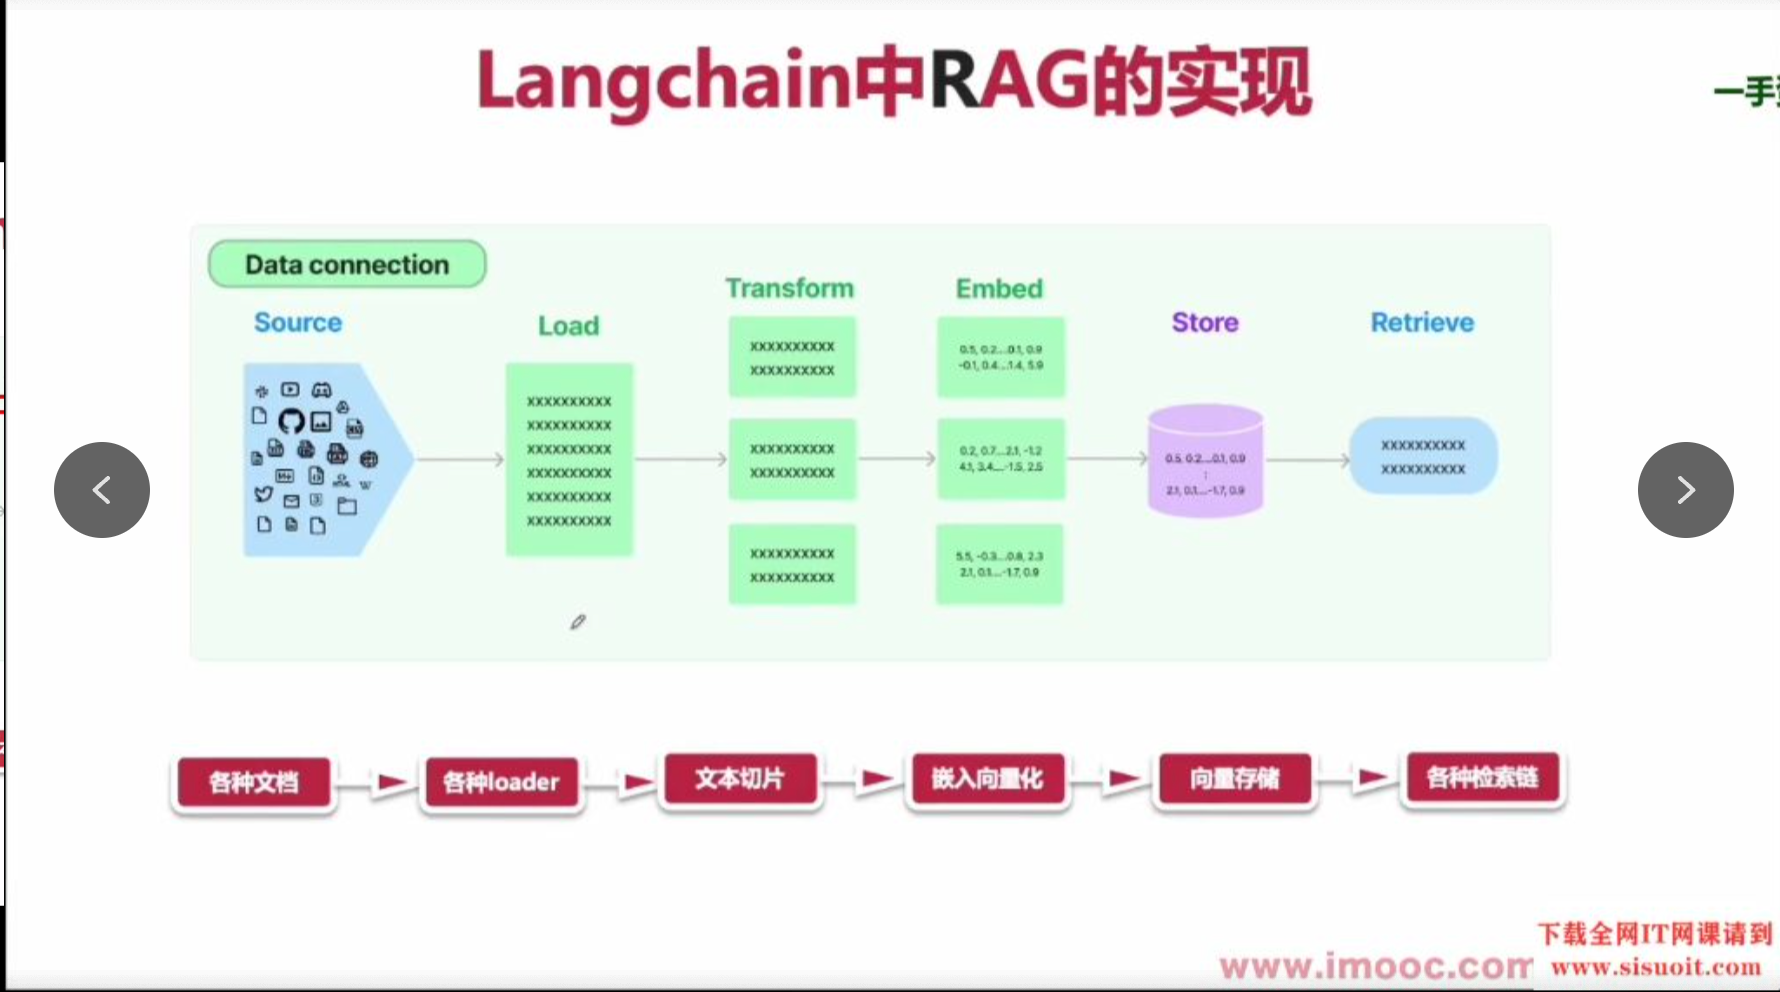

# 向量化处理
- 文本向量化Embedding
- 向量库

语义相似的文本的向量距离更接近

In [4]:
from langchain_community.document_loaders import TextLoader
# 方案1: 使用本地 HuggingFace 嵌入模型（推荐，避免网络问题）
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_text_splitters import CharacterTextSplitter

# 初始化本地嵌入模型（不依赖网络）
embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

embeddings = embedding_model.embed_documents(
     [
        "你好",
        "你好啊",
        "你叫什么名字?",
        "我叫王大锤",
        "很高兴认识你大锤",
    ]
)

embeddings

[[0.004036563448607922,
  0.015092170797288418,
  0.08047989010810852,
  0.0011475494829937816,
  0.015043577179312706,
  -0.004086101893335581,
  0.1167043000459671,
  0.014259646646678448,
  0.03392314910888672,
  -0.04262492060661316,
  0.0842844545841217,
  -0.08755876123905182,
  0.1009196788072586,
  0.00029238132992759347,
  -0.04886007681488991,
  -0.06992022693157196,
  0.032458994537591934,
  -0.004982750862836838,
  -0.03198341652750969,
  0.01340386364609003,
  -0.0650656446814537,
  0.04543415829539299,
  0.05426863208413124,
  0.02266361564397812,
  -0.07219979166984558,
  0.04094398766756058,
  -0.044502273201942444,
  0.018325040116906166,
  0.051655638962984085,
  -0.039104897528886795,
  0.009748287498950958,
  0.008628224022686481,
  -0.013037798926234245,
  -0.09796959161758423,
  0.038800179958343506,
  0.02469232864677906,
  -0.016042135655879974,
  -0.03199635073542595,
  -0.056151147931814194,
  0.034657713025808334,
  -0.06790444254875183,
  -0.0717897340655326

# Embde_query

In [5]:
embedded_query = embedding_model.embed_query("这段话中提到了什么名字？")
embedded_query[:5]

[-0.001144830952398479,
 0.1123349741101265,
 0.03893769904971123,
 0.019133172929286957,
 -0.09044330567121506]

# 嵌入向量缓存

In [16]:
from langchain_classic.embeddings import CacheBackedEmbeddings
from langchain_classic.storage import LocalFileStore
# 方案1: 使用本地 HuggingFace 嵌入模型（推荐，避免网络问题）
from langchain_huggingface import HuggingFaceEmbeddings
import hashlib
from  langchain_community.document_loaders import TextLoader
from langchain_text_splitters import CharacterTextSplitter
# 初始化本地嵌入模型（不依赖网络）
embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)
# 缓存向量
fs = LocalFileStore("./cache/")
cached_embeddings = CacheBackedEmbeddings.from_bytes_store(
    embedding_model,
    fs,
    # 移除 namespace 参数
    key_encoder=lambda x: hashlib.sha256(
        f"{embedding_model.model_name}:{x}".encode() if isinstance(x, str) else
        f"{embedding_model.model_name}:".encode() + x
    ).hexdigest()# 使用 SHA-256 编码器
)
list(fs.yield_keys())

# 切分文档，将切分的文档向量=存储在缓存中
raw_documents = TextLoader("resource/letter.txt").load()
text_splitter = CharacterTextSplitter(
    chunk_size=600,
    chunk_overlap=0,
)
documents = text_splitter.split_documents(raw_documents)


Created a chunk of size 610, which is longer than the specified 600


# 向量库

In [17]:
from langchain_community.vectorstores import FAISS
%timeit -r  1 -n 1 db= FAISS.from_documents(documents,cached_embeddings)


1.55 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [18]:
# 查看缓存中的键
list(fs.yield_keys())

['d474f68ce3a504c47a9887d6305d57f3d4978f7036f9603468fe158b2a4f4ac1',
 'a4204c5e2cfc81f78e0a24a29a668698927f41fe4142e90c82e1da0c1d34714d',
 'text-embedding-ada-002c63ea318-3b5d-533b-960b-46434f8b3c22',
 '7b48b620d282257e8df89047999c742c68784a81d2dac059f812a13377e6f9ed',
 'text-embedding-ada-002f05b40fb-a095-546e-9c5d-49e069720828',
 'ceddaa29004205578d799b236e262fa99ec37ca739f273779a27d3e1e1c96b4f',
 'text-embedding-ada-0024250f053-4b1e-5c34-927d-a7857749217f',
 'text-embedding-ada-002b0c54c27-a009-50b4-9ccc-661d5478b195',
 'text-embedding-ada-002e94acbbe-7d17-5331-8310-4e37bdc56d31',
 'f3a10406f9e53537b31eaedcb0e933e2b9f732dc9340d5570e69e800962e0967',
 'cac5fb570a91d61fda46261221d5411b4731a412572ffd0937961ef77308ff88',
 'text-embedding-ada-0029286d74c-b3fc-56ff-8b08-9071a193f724']

| 知识点 | 核心内容 | 关键步骤 / 技术要点 | 应用场景 |
|--------|-----------|----------------------|------------|
| 文本向量化（Embedding） | 将文本块转换为向量空间坐标，实现语义搜索 | 1. 数据加载<br>2. 文本变形（Transform）<br>3. 向量化处理<br>4. 存储至向量数据库 | 语义搜索、相似性匹配（如宠物分类：猫/狗 vs 牛/羊） |
| 向量化工具（LangChain） | 支持 OpenAI Embedding 等模型 | - embed_documents（文本块嵌入）<br>- embed_query（查询嵌入）<br>- 缓存机制（减少重复请求） | 开发效率优化、成本控制 |
| 缓存实现（LocalFileStorage） | 本地存储向量化结果 | 1. 创建缓存目录<br>2. 调用 CacheBackedEmbeddings<br>3. 检查缓存键值 | 高频查询场景、降低 API 调用成本 |
| 向量数据库（FAISS） | 高效存储和检索向量数据 | - 安装 faiss-cpu 包<br>- 时间对比测试（无缓存耗时 1.1 秒） | 大规模文本检索、实时语义分析 |
